# Second task: Data transformation

We decide to start this task performing data cleaning in order to improve the quality of our data before the feature enginering subtask. 

## Data cleaning

In the following section, we perform data cleaning on both datasets to enhance data quality and consistency. Each decision is made to address missing values, remove unnecessary attributes, and correct typing that could impact our analysis. This systematic approach ensures that both datasets are prepared for accurate and meaningful insights in the subsequent stages of our project.

In [215]:
import warnings
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import unidecode

from collections import defaultdict
from scipy.stats import pearsonr

import os

cyclists = pd.read_csv('./dataset/cyclists.csv')
races = pd.read_csv('./dataset/races.csv')

We start with the cyclists dataset, in particular with the weight and heigh values. It's easy to look that there are a lot of null values.

Our initial idea was to infer height from weight, and vice versa, in cases where only one of the two was missing. However, as we can see, out of approximately 6,000 null values for height and weight, this method allows us to deduce only 79.

In [216]:
count_hnn_wnn = cyclists[(cyclists['height'].isnull()) & (cyclists['weight'].isnull())].shape[0]
count_hn_wnn = cyclists[(cyclists['height'].isnull()) & (cyclists['weight'].notnull())].shape[0]
count_hnn_wn = cyclists[(cyclists['weight'].isnull()) & (cyclists['height'].notnull())].shape[0]

print(f"Number of cyclist with height and weight null: {count_hnn_wnn}")
print(f"Number of cyclist with height null and weight not null: {count_hn_wnn}")
print(f"Number of cyclist with height not null and weight null: {count_hnn_wn}")

Number of cyclist with height and weight null: 2984
Number of cyclist with height null and weight not null: 7
Number of cyclist with height not null and weight null: 72


To handle null values without altering the data distribution, we decided to fill them with the median. This approach is applied to weight, height.

Additionally, we decide to fill manually the single row in the table with a null nationality value to avoid discrepancies with the races dataset.

In [217]:
cyclists['weight'] = cyclists['weight'].fillna(cyclists['weight'].median())
cyclists['height'] = cyclists['height'].fillna(cyclists['height'].median())

cyclists.loc[cyclists['_url'] == 'scott-davies', 'nationality'] = 'Great Britain'

As a final operation on the cyclists database, we removed spaces from the names and then normalized them. Lastly, we checked for any discrepancies between names and their corresponding URLs. Observing that most discrepancies were not due to incorrect associations between different cyclists, but rather the presence of middle names or minor typos, we decided to retain these inconsistencies. We concluded that each cyclist is still uniquely identified by their URL.

In [218]:
# Normalize the name and remove the additional spaces
cyclists['name'] = cyclists['name'].str.replace(r'\s+', ' ', regex=True).str.strip()
cyclists['name'] = cyclists['name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')


def create_url_from_name(name):
    return unidecode.unidecode(name.lower().replace(" ", "-"))

# Find the discrepancies between the name and the URL
discrepancies = cyclists[cyclists['_url'] != cyclists['name'].apply(create_url_from_name)]

# Print the discrepancies
print(discrepancies[['_url', 'name']])

                                _url                    name
19                     michal-paluta            Micha Paluta
25                      graeme-brown      Graeme Allen Brown
32                   piotr-przydzial          Piotr Przydzia
49         jesus-rodriguez-rodriguez         Jesus Rodriguez
68             iban-herrero-atienzar            Ivan Herrero
...                              ...                     ...
6093  raul-alexander-montana-herrera  Raul Alexander Montana
6112      juan-carlos-jusdado-ibanez     Juan Carlos Jusdado
6113            joseba-albizu-lizaso           Joseba Albizu
6121          jacob-hindsgaul-madsen         Jacob Hindsgaul
6129         juan-jose-martinez-diaz      Juan Jose Martinez

[618 rows x 2 columns]


In the following we cleaning the data of the races database, in specific we:
- change all the string cyclists to lower case;
- cast the date column in datetime;
- drop of the uci_points column;
- drop of the average_temperature because there are too null elements;
- drop of the is_cobbled and is_gravels columns because they are all False;

In [219]:
# Handle cyclists with uppercase names
races['cyclist'] = races['cyclist'].str.lower()


# Find unique cyclist entries in each dataset
races_cyclists = races['cyclist'].unique()
cyclists_list = cyclists['_url'].unique()

# Identify cyclists in 'races' but not in 'cyclists'
missing_cyclists = set(races_cyclists) - set(cyclists_list)

# Display missing cyclists
print("Cyclists in 'races' but not in 'cyclists':", len(missing_cyclists))

# Cast date to datetime
races['date'] = pd.to_datetime(races['date'])

# Drop temperature column
races.drop('average_temperature', axis=1, inplace=True)

# Drop is_cobbled and is_gravel columns
races.drop(['is_cobbled', 'is_gravel'], axis=1, inplace=True)

Cyclists in 'races' but not in 'cyclists': 0


Regarding the cyclist_age in the 'races' dataset, we decided to calculate the age using the date field from races and the birth_year field from cyclists to ensure consistency between the two datasets, as shown in the following code.

In [220]:
# Fill missing cyclist_age values with the median
races['cyclist_age'] = races['cyclist_age'].fillna(races['cyclist_age'].median())

# Iterate over cyclists with missing birth_year and calculate birth_year using cyclist_age and date
for idx, row in cyclists[cyclists['birth_year'].isnull()].iterrows():
    cyclist_url = row['_url']
    
    # Find all rows in races for the specific cyclist
    relevant_races = races[races['cyclist'] == cyclist_url]
    
    # Calculate the birth year for each row and take the first valid value
    if not relevant_races.empty:
        calculated_birth_year = (relevant_races['date'].dt.year - relevant_races['cyclist_age']).dropna().iloc[0]
        cyclists.at[idx, 'birth_year'] = calculated_birth_year

In [221]:
# Merge the races dataset with cyclists based on '_url' (cyclist)
races_with_birth_year = races.merge(cyclists[['_url', 'birth_year']], left_on='cyclist', right_on='_url', how='left')

# Calculate the estimated birth year for each cyclist
discrepancies = races_with_birth_year[races_with_birth_year.apply(
    lambda row: row['birth_year'] != (row['date'].year - row['cyclist_age']), 
    axis=1
)]

# Display the number of discrepancies found
print(f"Discrepancies found: {discrepancies.shape[0]}")

# Show cyclist name, calculated year, and birth_year
discrepancies[['cyclist', 'date', 'birth_year']].assign(calculated_birth_year = discrepancies['date'].dt.year - discrepancies['cyclist_age'])

Discrepancies found: 24


,cyclist,date,birth_year,calculated_birth_year
6495,scott-davies,2020-10-27 04:05:14,1991.0,1992.0
12865,scott-davies,2018-04-15 06:39:57,1991.0,1990.0
12972,scott-davies,2020-10-31 05:26:30,1991.0,1992.0
60389,scott-davies,2020-10-23 03:54:11,1991.0,1992.0
189206,scott-davies,2020-11-08 03:28:49,1991.0,1992.0
217425,scott-davies,2020-10-24 04:32:14,1991.0,1992.0
250596,alexandr-osipov,1986-04-23 04:47:10,1957.0,1958.0
283649,scott-davies,2018-06-13 03:56:07,1991.0,1990.0
324670,scott-davies,2020-10-29 03:41:45,1991.0,1992.0
329037,scott-davies,2020-10-21 04:02:30,1991.0,1992.0


After this operation we found 24 discrepancies regading two cyclists. We decide to update them with the cyclist_age to mantain consistency.

In [222]:
# Change the cyclyst_age in a consistent way respect to birth_year
birth_year = cyclists.loc[cyclists['_url'] == 'alexandr-osipov', 'birth_year'].values[0]

if pd.notnull(birth_year):
    for idx, row in races[races['cyclist'] == 'alexandr-osipov'].iterrows():
        calculated_age = row['date'].year - birth_year
        races.at[idx, 'cyclist_age'] = calculated_age

birth_year = cyclists.loc[cyclists['_url'] == 'scott-davies', 'birth_year'].values[0]

if pd.notnull(birth_year):
    for idx, row in races[races['cyclist'] == 'scott-davies'].iterrows():
        calculated_age = row['date'].year - birth_year
        races.at[idx, 'cyclist_age'] = calculated_age

# Merge the races dataset with cyclists based on '_url' (cyclist)
races_with_birth_year = races.merge(cyclists[['_url', 'birth_year']], left_on='cyclist', right_on='_url', how='left')

# Calculate the estimated birth year for each cyclist
discrepancies = races_with_birth_year[races_with_birth_year.apply(
    lambda row: row['birth_year'] != (row['date'].year - row['cyclist_age']), 
    axis=1
)]

# Display the number of discrepancies found
print(f"Discrepancies found: {discrepancies.shape[0]}")

Discrepancies found: 0


The uci_points column has more than half of its values missing, and checks confirmed that stages either entirely lack or fully contain uci_points without partial entries. Since points already provides similar, consistently populated information, uci_points adds little value and can be removed to reduce data sparsity and improve dataset quality.

In [223]:
race_uciponts_partial = races.groupby('_url')['uci_points'].transform(lambda x: x.isnull().any() and x.notnull().any()).sum()
print(f"Number of entry with partial UCi points values to derive the entire stage: {race_uciponts_partial}")

# Drop of the UCi points column
races.drop('uci_points', axis=1, inplace=True)

Number of entry with partial UCi points values to derive the entire stage: 0


Then we fill all the null values, in the numeric attributes that cannot be completed using the mean or median we use the symbolic values "-1" and for the string one we use the "unknown".
We decide to do that to easily remove the symbolic values from the database during the plot fase.

In [224]:
races['profile'] = races['profile'].fillna(-1).astype(int)
races['climb_total'] = races['climb_total'].fillna(-1).astype(int)
races['cyclist_team'] = races['cyclist_team'].fillna('unknown')
races['cyclist_age'] = races['cyclist_age'].fillna(races['cyclist_age'].median()).astype(int)
races['points'] = races['points'].fillna(races['points'].median()).astype(int)

Now that we have a dataset without null values and with unnecessary columns removed, we can proceed to the next subtask.

## Feature engineering and novel feature definition

The first feature we decided to derive is BMI (Body Mass Index), which we added as a new column in the 'cyclists' dataset. BMI is calculated as the weight (in kg) divided by the square of the height (in meters)

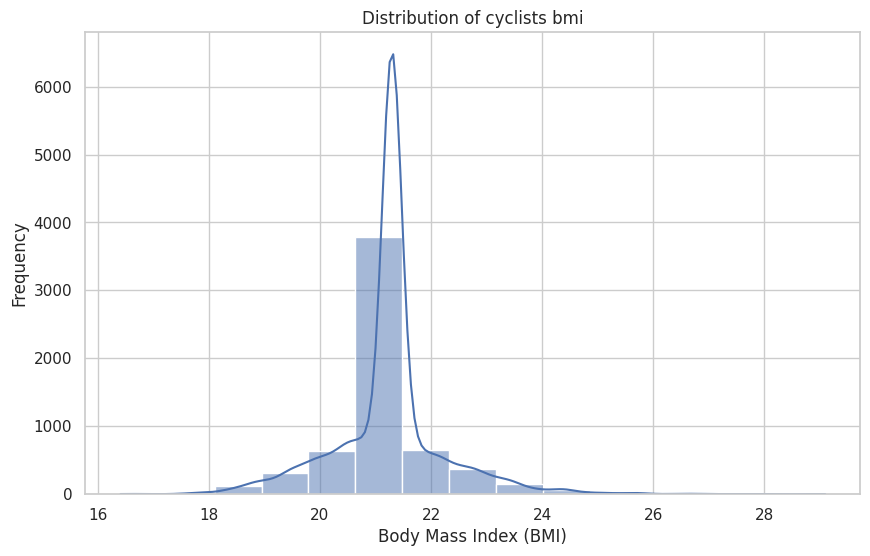

In [225]:
cyclists['bmi'] = cyclists['weight'] / (cyclists['height'] / 100) ** 2

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(cyclists['bmi'],bins=15, kde=True)
plt.title('Distribution of cyclists bmi')
plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Frequency')
plt.show()

Next, we derive a new feature by mapping each cyclist to their respective continent based on nationality.

Percentage of Cyclists by Continent:
Europe: 85.65%
South America: 4.09%
Asia: 3.42%
North America: 3.37%
Australia: 2.69%
Africa: 0.77%


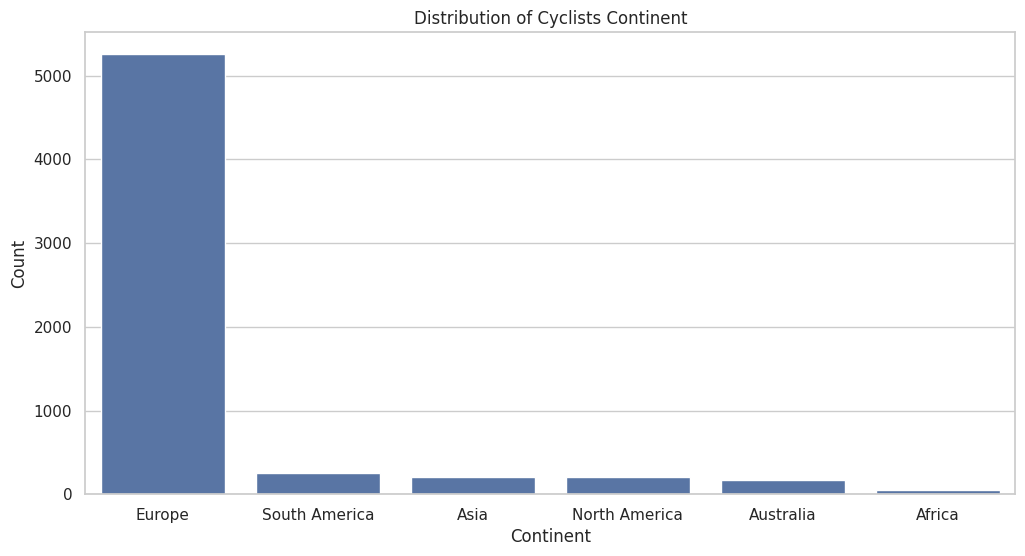

In [226]:
unique_nationalities = cyclists['nationality'].unique()

# Mapping of nationalities to continents
continent_map = {
    'Italy': 'Europe',
    'France': 'Europe',
    'Netherlands': 'Europe',
    'Belgium': 'Europe',
    'Spain': 'Europe',
    'United States': 'North America',
    'Norway': 'Europe',
    'Russia': 'Asia',
    'Poland': 'Europe',
    'Germany': 'Europe',
    'Australia': 'Australia',
    'Switzerland': 'Europe',
    'Ireland': 'Europe',
    'Denmark': 'Europe',
    'Great Britain': 'Europe',
    'Colombia': 'South America',
    'South Africa': 'Africa',
    'Argentina': 'South America',
    'New Zealand': 'Australia',
    'Lithuania': 'Europe',
    'Portugal': 'Europe',
    'Austria': 'Europe',
    'Yugoslavia': 'Europe',
    'Estonia': 'Europe',
    'Romania': 'Europe',
    'Slovenia': 'Europe',
    'Canada': 'North America',
    'Latvia': 'Europe',
    'Luxembourg': 'Europe',
    'Sweden': 'Europe',
    'Czech Republic': 'Europe',
    'Slovakia': 'Europe',
    'Morocco': 'Africa',
    'Ukraine': 'Europe',
    'Ethiopia': 'Africa',
    'Belarus': 'Europe',
    'Venezuela': 'South America',
    'Japan': 'Asia',
    'Mexico': 'North America',
    'Croatia': 'Europe',
    'Kazakhstan': 'Asia',
    'Uruguay': 'South America',
    'Israel': 'Asia',
    'Namibia': 'Africa',
    'Eritrea': 'Africa',
    'Costa Rica': 'North America',
    'Taiwan': 'Asia',
    'Azerbaijan': 'Asia',
    'Hungary': 'Europe',
    'Moldova': 'Europe',
    'Panama': 'North America',
    'Finland': 'Europe',
    'Bulgaria': 'Europe',
    'Serbia': 'Europe',
    'Brazil': 'South America',
    'Iran': 'Asia',
    'Greece': 'Europe',
    'Chile': 'South America',
    'Ecuador': 'South America',
    'China': 'Asia',
    'Albania': 'Europe',
    'Guatemala': 'North America',
    'Uzbekistan': 'Asia',
    'Algeria': 'Africa',
    'Tunisia': 'Africa',
    'Monaco': 'Europe',
    'Rwanda': 'Africa',
    'Dominican Republic': 'North America',
    'Liechtenstein': 'Europe',
    'Zimbabwe': 'Africa',
    'Puerto Rico': 'North America',
    'Hongkong': 'Asia',
}

# Map the 'nationality' column to the new 'continent' column
cyclists['continent'] = cyclists['nationality'].map(continent_map)

# Calculate the percentage of cyclists from each continent
continent_percentage = cyclists['continent'].value_counts(normalize=True) * 100
print("Percentage of Cyclists by Continent:")
for continent, percentage in continent_percentage.items():
    print(f"{continent}: {percentage:.2f}%")

plt.figure(figsize=(12, 6))
sns.countplot(data=cyclists, x='continent', order=cyclists['continent'].value_counts().index)
plt.title('Distribution of Cyclists Continent')
plt.xlabel('Continent')
plt.ylabel('Count')
plt.show()

As last features for cyclists, we introduce average position for further computation in the clustering task.
We will introduce also average delta, but first we have to clean the column from the outliers.
Since there are a few cyclists non-corresponding between the two datasets, we fill the missing values with the median.

In [227]:
# Add the feature 'avg_position' in cyclists
cyclists = cyclists.merge(races.groupby('cyclist', as_index=False)['position'].mean(), left_on='_url', right_on='cyclist', how='left')
cyclists.rename(columns={'position': 'avg_position'}, inplace=True)

# Fill the missing values in 'avg_position' with the median
cyclists['avg_position'] = cyclists['avg_position'].fillna(cyclists['avg_position'].median())

# Drop of cyclist column
cyclists.drop('cyclist', axis=1, inplace=True)

# Cast the 'avg_position' column to integer
cyclists['avg_position'] = cyclists['avg_position'].astype(int)

Now, moving on to the races dataset, we decided to add a feature representing the four seasons to better categorize the time of year in which each race took place.

Percentage of Races for season:
spring: 43.09%
summer: 41.80%
autumn: 13.92%
winter: 1.19%


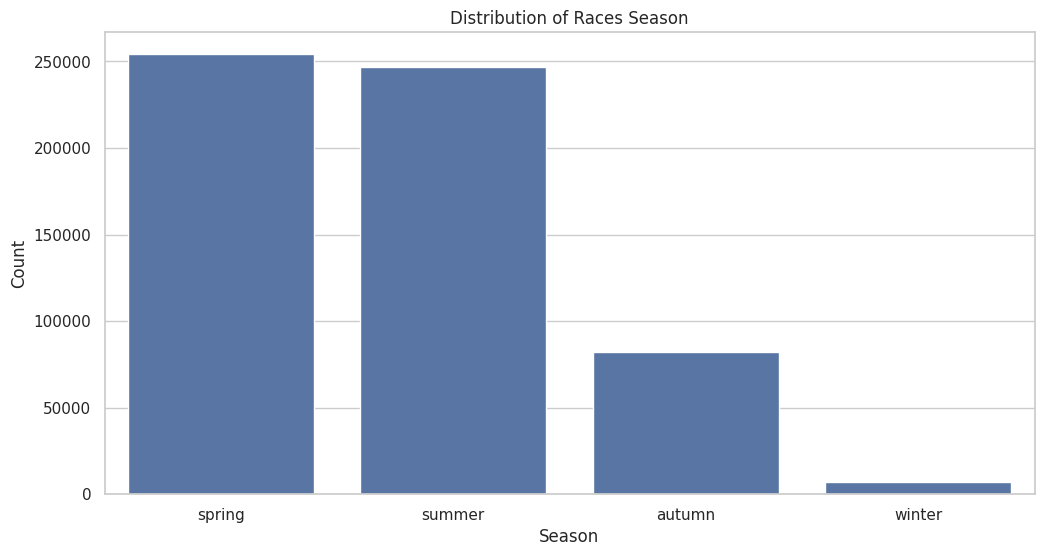

In [228]:
# Create 'month' and 'season' columns
races['month'] = races['date'].dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

races['season'] = races['month'].apply(get_season)


# Calculate the percentage of races for each season
season_percentage = races['season'].value_counts(normalize=True) * 100
print("Percentage of Races for season:")
for season, percentage in season_percentage.items():
    print(f"{season}: {percentage:.2f}%")

plt.figure(figsize=(12, 6))
sns.countplot(data=races, x='season', order=races['season'].value_counts().index)
plt.title('Distribution of Races Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()


The race_intensity feature is calculated as a weighted combination of three components. First, it considers the ratio of climb_total to length, which represents the steepness of the race. Next, it incorporates the profile score, indicating the overall difficulty level of the terrain. Finally, a logarithmic transformation of length is applied to capture the effect of distance on race intensity

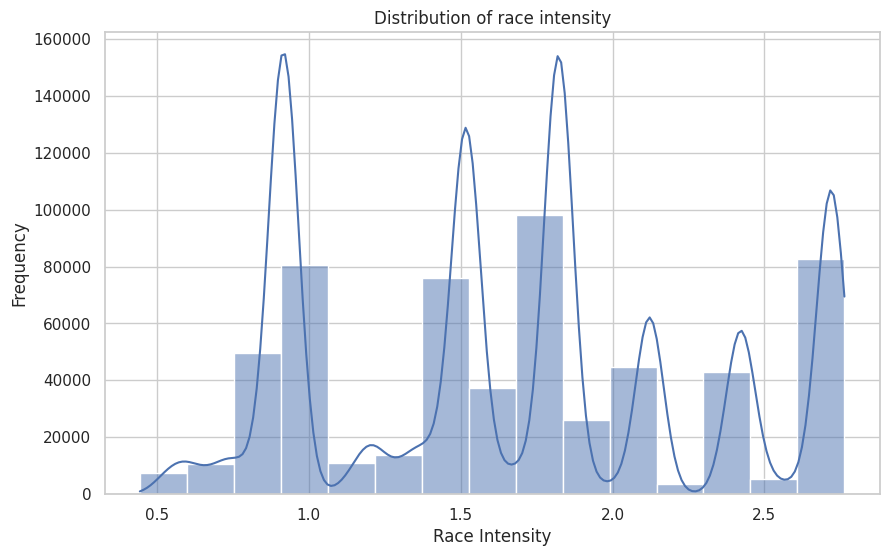

In [229]:
# We use a ratio of 'climb_total' to 'length', add a scaled 'profile', and apply a logarithmic transformation to 'length'
races['race_intensity'] = 0.6 * (races['climb_total'] / races['length']) + 0.3 * races['profile'] + 0.1 * races['length'].apply(math.log)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(races['race_intensity'],bins=15, kde=True)
plt.title('Distribution of race intensity')
plt.xlabel('Race Intensity')
plt.ylabel('Frequency')
plt.show()

Our datasets at this point have the following structures:

In [230]:
cyclists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _url          6134 non-null   object 
 1   name          6134 non-null   object 
 2   birth_year    6134 non-null   float64
 3   weight        6134 non-null   float64
 4   height        6134 non-null   float64
 5   nationality   6134 non-null   object 
 6   bmi           6134 non-null   float64
 7   continent     6134 non-null   object 
 8   avg_position  6134 non-null   int64  
dtypes: float64(4), int64(1), object(4)
memory usage: 431.4+ KB


In [231]:
races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   _url               589865 non-null  object        
 1   name               589865 non-null  object        
 2   points             589865 non-null  int64         
 3   length             589865 non-null  float64       
 4   climb_total        589865 non-null  int64         
 5   profile            589865 non-null  int64         
 6   startlist_quality  589865 non-null  int64         
 7   date               589865 non-null  datetime64[ns]
 8   position           589865 non-null  int64         
 9   cyclist            589865 non-null  object        
 10  cyclist_age        589865 non-null  int64         
 11  is_tarmac          589865 non-null  bool          
 12  cyclist_team       589865 non-null  object        
 13  delta              589865 non-null  float64 

## Outlier detection

Since we compleated the first subtask introducing the new features, we can carry on with the outlier detection task. Starting with the numerical value we decide to use the two principal techniques for our purpose: *Z-score* for the data with roughly normal distribution and *Interquartile Range (IQR)* method for all the others.

In [232]:
# Definition of the two function for the outliers detection

# Interquartile range method
def detect_outliers_iqr(data, column):
    # Calculate the first (Q1) and third (Q3) quartiles
    Q1 = data[column].quantile(0.25)  # 25th percentile
    Q3 = data[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1                     # Interquartile range
    
    # Determine the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers as values outside the lower and upper bounds
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Z-score method
def detect_outliers_zscore(data, column, threshold=3):
    # Calculate the Z-scores for the specified column
    z_scores = stats.zscore(data[column])
    
    # Identify outliers based on the specified threshold (default is 3)
    outliers = data[abs(z_scores) > threshold]
    return outliers

The first attribute we consider is birth_year in the cyclists dataset. In this case we employ IQR because the distribution saw in the first task isn't a normal one. We can see that there aren't anomalous value.

In [233]:
detect_outliers_iqr(cyclists, 'birth_year')

,_url,name,birth_year,weight,height,nationality,bmi,continent,avg_position


Now we can analyse the weight, height and bmi features. For the first two, we can see that the returned few values are not unlikely (also for professional cyclists).

In [234]:
detect_outliers_zscore(cyclists, 'weight', threshold=5)

,_url,name,birth_year,weight,height,nationality,bmi,continent,avg_position
4554,gerrit-solleveld,Gerrit Solleveld,1961.0,93.0,183.0,Netherlands,27.770313,Europe,113
5490,soren-waerenskjold,Sren Wrenskjold,2000.0,92.0,195.0,Norway,24.194609,Europe,93
5913,magnus-backstedt,Magnus Backstedt,1975.0,94.0,194.0,Sweden,24.976087,Europe,84


In [235]:
detect_outliers_zscore(cyclists, 'height', threshold=5)

,_url,name,birth_year,weight,height,nationality,bmi,continent,avg_position
679,conor-dunne,Conor Dunne,1992.0,88.0,204.0,Ireland,21.145713,Europe,134
720,vicente-belda,Vicente Belda,1954.0,69.0,154.0,Spain,29.094282,Europe,49
1818,alfons-de-bal,Alfons De Bal,1943.0,69.0,155.0,Belgium,28.720083,Europe,14


Some interesting values come out from the bmi feature that can be compared with the BMI scale: infact, all the values under 18 are underweight and over 25 are overweight. Althought this, we do not modify the dataset since, even if they are athletes, these values are normally likely. 

In [236]:
detect_outliers_zscore(cyclists, 'bmi', threshold=4)

,_url,name,birth_year,weight,height,nationality,bmi,continent,avg_position
720,vicente-belda,Vicente Belda,1954.0,69.0,154.0,Spain,29.094282,Europe,49
857,jon-ander-insausti,Jon Ander Insausti,1992.0,89.0,187.0,Spain,25.451114,Europe,54
1067,daniel-arroyave-canas,Daniel Arroyave,2000.0,52.0,178.0,Colombia,16.412069,South America,133
1352,michael-friedman,Michael Friedman,1982.0,82.0,175.0,United States,26.775510,North America,117
1487,michael-kolar,Michael Kolar,1992.0,90.0,185.0,Slovakia,26.296567,Europe,115
1534,john-degenkolb,John Degenkolb,1989.0,82.0,180.0,Germany,25.308642,Europe,80
1818,alfons-de-bal,Alfons De Bal,1943.0,69.0,155.0,Belgium,28.720083,Europe,14
2192,javier-francisco-elorriaga,Javier Francisco Elorriaga,1947.0,85.0,179.0,Spain,26.528510,Europe,38
2250,paulino-martinez,Paulino Martinez,1952.0,80.0,176.0,Spain,25.826446,Europe,81
3174,massimiliano-mori,Massimiliano Mori,1974.0,77.0,174.0,Italy,25.432686,Europe,88


For the points entry in races, we don't perform any method since we have different range of values unrelated between them and so it isn't meaningful to search for outliers.

For the length feature, due to its asymmetric and multimodal distribution, we opted for the IQR method to identify outliers. Although this approach flagged numerous data points as potential outliers, we chose to retain them since they were neither improbable, negative, nor unrealistically large.

In [237]:
outlier_iqr_length = detect_outliers_iqr(races, 'length')

outlier_iqr_length.drop_duplicates(subset='_url')

,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,month,season,race_intensity
426,volta-a-catalunya/1999/prologue,Volta Ciclista a Catalunya,50,8100.0,-1,-1,804,1999-06-17 00:10:12,0,angel-luis-casero,27,True,euskaltel-euskadi-2010,0.0,6,summer,0.599888
866,tour-de-france/1978/stage-14,Tour de France,100,52000.0,1351,5,1241,1978-07-14 01:25:51,0,joop-zoetemelk,32,True,spain-1991,0.0,7,summer,2.601488
1075,volta-a-catalunya/1981/stage-2b,Volta Ciclista a Catalunya,50,30000.0,-1,-1,388,1981-09-05 00:44:24,0,aad-van-den-hoek,30,True,unknown,0.0,9,autumn,0.730875
1084,paris-nice/1994/stage-8b,Paris - Nice,50,12500.0,-1,-1,900,1994-03-13 00:22:06,0,tony-rominger,33,True,ag2r-prevoyance-2001,0.0,3,spring,0.643300
1483,milano-sanremo/2004/result,Milano-Sanremo,275,294000.0,-1,-1,1400,2004-03-20 07:11:23,0,oscar-freire,28,False,kazakhstan-2022,0.0,3,spring,0.959131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585303,milano-sanremo/2019/result,Milano-Sanremo,275,291000.0,2060,2,1171,2019-03-23 06:40:14,0,julian-alaphilippe,27,False,del-tongo-1986,0.0,3,spring,1.862355
585665,tour-de-france/1990/stage-5,Tour de France,100,301000.0,3365,1,1959,1990-07-04 07:43:07,0,gerrit-solleveld,29,True,liberty-seguros-wurth-team-2005,0.0,7,summer,1.568194
585859,milano-sanremo/1996/result,Milano-Sanremo,275,294000.0,-1,-1,1580,1996-03-23 07:00:27,0,gabriele-colombo,24,False,rally-cycling-2021,0.0,3,spring,0.959131
587372,vuelta-a-espana/1997/stage-21,Vuelta a España,80,43000.0,477,-1,1165,1997-09-27 00:51:35,0,alex-zulle,29,True,germany-2004,0.0,9,autumn,0.773551


For the same reason as above, the IQR method was also applied to the 'climb_total' feature. This analysis did not identify any values that could be considered outliers.

In [238]:
detect_outliers_iqr(races, 'climb_total')

,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,month,season,race_intensity


Regarding cyclist_age, a more thorough analysis was conducted by applying both the IQR and Z-score methods. The first observation is that, since these values are consistent with birth_year in the cyclists dataset, they all appear plausible. Nonetheless, the IQR method highlighted over 4,000 entries corresponding to around a hundred cyclists with ages that are outside the typical range (particularly those over 40 years old). On the other hand, the Z-score method, with an appropriate threshold, find only one cyclist.

In [239]:
outlier_iqr_cyclist_age = detect_outliers_iqr(races, 'cyclist_age')

print(f"{len(outlier_iqr_cyclist_age['cyclist'].unique())}")

outlier_zs_cyclist_age = detect_outliers_zscore(races, 'cyclist_age', threshold=5)

print(f"{len(outlier_zs_cyclist_age['cyclist'].unique())}")

112
1


In [240]:
outlier_iqr_cyclist_age

,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,month,season,race_intensity
111,vuelta-a-espana/2016/stage-14,Vuelta a España,80,196000.0,5575,5,821,2016-09-03 05:44:13,5,haimar-zubeldia,39,True,linea-md-italia-maggi-mobili-1985,49.0,9,autumn,2.735653
129,vuelta-a-espana/2016/stage-14,Vuelta a España,80,196000.0,5575,5,821,2016-09-03 05:46:35,23,jean-christophe-peraud,39,True,kazakhstan-2019,191.0,9,autumn,2.735653
241,vuelta-a-espana/2016/stage-14,Vuelta a España,80,196000.0,5575,5,821,2016-09-03 06:22:05,135,svein-tuft,39,True,unknown,2321.0,9,autumn,2.735653
287,tour-de-france/2019/stage-21,Tour de France,100,128000.0,781,1,1699,2019-07-28 03:04:08,16,alejandro-valverde,39,True,netherlands-1974,0.0,7,summer,1.479639
359,tour-de-france/2019/stage-21,Tour de France,100,128000.0,781,1,1699,2019-07-28 03:04:45,88,lars-ytting-bak,39,True,team-giant-shimano-2014,37.0,7,summer,1.479639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589598,volta-a-catalunya/2016/stage-7,Volta Ciclista a Catalunya,50,136400.0,1880,2,1045,2016-03-27 03:16:14,56,haimar-zubeldia,39,True,linea-md-italia-maggi-mobili-1985,161.0,3,spring,1.790604
589617,volta-a-catalunya/2016/stage-7,Volta Ciclista a Catalunya,50,136400.0,1880,2,1045,2016-03-27 03:19:20,75,paolo-tiralongo,39,True,ceramica-panaria-navigare-2007,347.0,3,spring,1.790604
589746,giro-d-italia/2010/stage-1,Giro d'Italia,80,8400.0,60,1,878,2010-05-08 00:10:54,78,alessandro-bertolini,39,True,team-saxo-bank-tinkoff-bank-2012,36.0,5,spring,1.207884
589764,giro-d-italia/2010/stage-1,Giro d'Italia,80,8400.0,60,1,878,2010-05-08 00:11:00,96,inigo-cuesta,41,True,unknown,42.0,5,spring,1.207884


In [241]:
outlier_zs_cyclist_age

,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,month,season,race_intensity
114525,vuelta-a-espana/1996/stage-1,Vuelta a España,80,162000.0,862,-1,988,1996-09-07 03:52:27,129,jose-azevedo-goncalves,56,True,unknown,0.0,9,autumn,0.902728


We can confirmed what was observed in the preliminary analysis: the presence of two cyclists with notably unusual ages, 13 and 56 years. We have decided to leave them in the dataset as they are for now.

In [242]:
races[((races['cyclist_age'] < 17) | (races['cyclist_age'] > 45))]

,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,month,season,race_intensity
114525,vuelta-a-espana/1996/stage-1,Vuelta a España,80,162000.0,862,-1,988,1996-09-07 03:52:27,129,jose-azevedo-goncalves,56,True,unknown,0.0,9,autumn,0.902728
294489,san-sebastian/2001/result,Clasica Ciclista San Sebastian,225,227000.0,-1,2,1048,2001-08-11 05:28:57,91,plamen-stanev,13,False,unknown,663.0,8,summer,1.833268


Moving on to the delta analysis, the first step was to check for values below zero. It was decided to replace these negative values with those of the preceding rows to maintain the consistency of an increasing delay. A cyclist should not have a smaller delay than the one before them, so this correction helps prevent data anomalies. Subsequently, the IQR method was applied, confirming that no further modifications or removals were needed, as the data fell within a reasonable threshold.

In [243]:
races[races['delta'] < 0]

,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,month,season,race_intensity
70651,vuelta-a-espana/1992/stage-19,Vuelta a España,80,37900.0,294,-1,1033,1992-05-15 00:02:23,10,johan-bruyneel,28,True,ville-de-charleroi-new-systems-2000,-2635.0,5,spring,0.758925
70652,vuelta-a-espana/1992/stage-19,Vuelta a España,80,37900.0,294,-1,1033,1992-05-15 00:02:20,11,raul-alcala,28,True,team-volksbank-2008,-2638.0,5,spring,0.758925
70653,vuelta-a-espana/1992/stage-19,Vuelta a España,80,37900.0,294,-1,1033,1992-05-15 00:03:57,12,joachim-halupczok,24,True,unknown,-2541.0,5,spring,0.758925
70654,vuelta-a-espana/1992/stage-19,Vuelta a España,80,37900.0,294,-1,1033,1992-05-15 00:03:56,13,djamolidine-abduzhaparov,28,True,south-africa-2022,-2542.0,5,spring,0.758925
70655,vuelta-a-espana/1992/stage-19,Vuelta a España,80,37900.0,294,-1,1033,1992-05-15 00:03:53,14,guido-bontempi,32,True,south-africa-2022,-2545.0,5,spring,0.758925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229670,paris-nice/1990/stage-7a,Paris - Nice,50,102000.0,-1,-1,995,1990-03-11 00:55:03,7,laurent-jalabert,22,True,kazakhstan-2022,-5562.0,3,spring,0.853267
229671,paris-nice/1990/stage-7a,Paris - Nice,50,102000.0,-1,-1,995,1990-03-11 00:55:03,8,claudio-chiappucci,27,True,csf-group-navigare-2008,-5562.0,3,spring,0.853267
229672,paris-nice/1990/stage-7a,Paris - Nice,50,102000.0,-1,-1,995,1990-03-11 00:32:39,9,jean-claude-colotti,29,True,jolly-ceramica-1977,-6906.0,3,spring,0.853267
413492,tour-de-france/2003/stage-12,Tour de France,100,47000.0,712,2,1688,2003-07-18 00:09:35,104,leonardo-bertagnolli,25,True,team-saxo-bank-tinkoff-bank-2012,-2937.0,7,summer,1.684880


In [244]:
# Sobstitute the negative values with the previous value
races['delta'] = races['delta'].mask(races['delta'] < 0).ffill()

detect_outliers_iqr(races, 'delta')

,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,month,season,race_intensity
178,vuelta-a-espana/2016/stage-14,Vuelta a España,80,196000.0,5575,5,821,2016-09-03 06:10:24,72,axel-domont,26,True,kazakhstan-2019,1620.0,9,autumn,2.735653
179,vuelta-a-espana/2016/stage-14,Vuelta a España,80,196000.0,5575,5,821,2016-09-03 06:10:24,73,clement-chevrier,24,True,mexico-1986,1620.0,9,autumn,2.735653
180,vuelta-a-espana/2016/stage-14,Vuelta a España,80,196000.0,5575,5,821,2016-09-03 06:10:24,74,odd-christian-eiking,22,True,canada-1996,1620.0,9,autumn,2.735653
181,vuelta-a-espana/2016/stage-14,Vuelta a España,80,196000.0,5575,5,821,2016-09-03 06:10:24,75,koen-bouwman,23,True,new-zealand-1991,1620.0,9,autumn,2.735653
182,vuelta-a-espana/2016/stage-14,Vuelta a España,80,196000.0,5575,5,821,2016-09-03 06:10:24,76,merhawi-kudus,22,True,ireland-2005,1620.0,9,autumn,2.735653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589197,tour-de-france/2010/stage-8,Tour de France,100,189000.0,3636,5,1685,2010-07-11 05:26:45,177,francesco-reda,28,True,spain-1991,1954.0,7,summer,2.726493
589198,tour-de-france/2010/stage-8,Tour de France,100,189000.0,3636,5,1685,2010-07-11 05:26:45,178,serge-pauwels,27,True,o.n.c.e.-deutsche-bank-2000,1954.0,7,summer,2.726493
589199,tour-de-france/2010/stage-8,Tour de France,100,189000.0,3636,5,1685,2010-07-11 05:26:45,179,stephen-cummings,29,True,o.n.c.e.-deutsche-bank-2000,1954.0,7,summer,2.726493
589200,tour-de-france/2010/stage-8,Tour de France,100,189000.0,3636,5,1685,2010-07-11 05:26:45,180,thor-hushovd,32,True,switzerland-1997,1954.0,7,summer,2.726493


As stated previously, we add the average delta feature.

In [245]:
# Add the feature 'avg_delta' in cyclists
cyclists = cyclists.merge(races.groupby('cyclist', as_index=False)['delta'].mean(), left_on='_url', right_on='cyclist', how='left')
cyclists.rename(columns={'delta': 'avg_delta'}, inplace=True)

# Fill the missing values in 'avg_delta' with the median
cyclists['avg_delta'] = cyclists['avg_delta'].fillna(cyclists['avg_delta'].median())

# Drop of cyclist column
cyclists.drop('cyclist', axis=1, inplace=True)
cyclists.describe()

,birth_year,weight,height,bmi,avg_position,avg_delta
count,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000
mean,1974.055103,68.828758,179.905282,21.257522,75.971797,442.609787
std,15.529270,4.499758,4.612879,1.002321,33.010333,243.941882
min,1933.000000,48.000000,154.000000,16.412069,0.000000,0.000000
25%,1962.000000,69.000000,180.000000,21.132713,54.000000,280.190476
50%,1974.000000,69.000000,180.000000,21.296296,78.000000,426.851259
75%,1987.000000,69.000000,180.000000,21.296296,98.000000,575.500000
max,2004.000000,94.000000,204.000000,29.094282,205.000000,2858.428571


The last numerical value to analyze is race_intensity, which we derived from climb_total, length, and profile. We have already observed that it does not follow a normal distribution, so we use the IQR method. As aspected there isn't outliers values, all the values are between 0,4 and 2,7.

In [246]:
detect_outliers_iqr(races, 'race_intensity')

,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,month,season,race_intensity


In [247]:
races['race_intensity'].describe()

count    589865.000000
mean          1.700245
std           0.629415
min           0.443485
25%           0.960166
50%           1.790525
75%           2.126757
max           2.763630
Name: race_intensity, dtype: float64

Now we can save the cleaned and processed datasets.

In [248]:
cyclists.info()
cyclists.to_csv('dataset/cyclists_trasformed.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _url          6134 non-null   object 
 1   name          6134 non-null   object 
 2   birth_year    6134 non-null   float64
 3   weight        6134 non-null   float64
 4   height        6134 non-null   float64
 5   nationality   6134 non-null   object 
 6   bmi           6134 non-null   float64
 7   continent     6134 non-null   object 
 8   avg_position  6134 non-null   int64  
 9   avg_delta     6134 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 479.3+ KB


In [249]:
races.info()
races.to_csv('dataset/races_trasformed.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   _url               589865 non-null  object        
 1   name               589865 non-null  object        
 2   points             589865 non-null  int64         
 3   length             589865 non-null  float64       
 4   climb_total        589865 non-null  int64         
 5   profile            589865 non-null  int64         
 6   startlist_quality  589865 non-null  int64         
 7   date               589865 non-null  datetime64[ns]
 8   position           589865 non-null  int64         
 9   cyclist            589865 non-null  object        
 10  cyclist_age        589865 non-null  int64         
 11  is_tarmac          589865 non-null  bool          
 12  cyclist_team       589865 non-null  object        
 13  delta              589865 non-null  float64 